<h2><center> <span style = "font-family: Babas; font-size: 2em;"> Part 2 : Implementing Logistic Regression from Scratch </span> </center></h2>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Davy Bayet </span> </center></h4>

### Contents

- [Introduction](#Introduction)
- [Logistic Function](#Logistic-Function)
- [Log Loss](#Log-Loss)
- [Cost Function](#Cost-Function)
- [Gradient Descent](#Gradient-Descent)
- [Preprocessing](#Preprocessing)
- [Model Fitting](#Model-Fitting)
- [Prediction and Evaluation](#Prediction-and-Evaluation)
- [Regularization](#Regularization)
- [Acknowledgements](#Acknowledgements)
- [References](#References)

In [1]:
# Importing libraries
import time, psutil, os, math
from tqdm.contrib import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split

In [2]:
# Runtime and memory usage
start = time.time()
process = psutil.Process(os.getpid())

# Introduction

**Classification.** In [statistics](https://en.wikipedia.org/wiki/Statistics) and [machine learning](https://en.wikipedia.org/wiki/Machine_learning), [classification](https://en.wikipedia.org/wiki/Statistical_classification) refers to a type of [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning). For this task, training data with known class labels are given and is used to develop a [classification rule](https://en.wikipedia.org/wiki/Classification_rule) for assigning new unlabeled data to one of the classes. A special case of the task is [binary classification](https://en.wikipedia.org/wiki/Binary_classification), which involves only two classes. Some examples:

- Classifying an email as `spam` or `non-spam`
- Classifying a tumor as `benign` or `malignant`

The algorithms that sort unlabeled data into labeled classes are called *classifiers*. Loosely speaking, the [sorting hat](https://en.wikipedia.org/wiki/Magical_objects_in_Harry_Potter#Sorting_Hat) from [Hogwarts](https://en.wikipedia.org/wiki/Hogwarts) can be thought of as a classifier that sorts incoming students into four distinct houses. In real life, some common classifiers are [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), [k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), [decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning), [random forest](https://en.wikipedia.org/wiki/Random_forest), [support vector machine](https://en.wikipedia.org/wiki/Support-vector_machine), [naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier), [linear discriminant analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis), [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), [XGBoost](https://en.wikipedia.org/wiki/XGBoost), [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost) and [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network).

**The purpose of the notebook.** Many advanced libraries, such as [scikit-learn](https://en.wikipedia.org/wiki/Scikit-learn), make it possible for us to train various models on labeled [training data](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets#Training_data_set), and predict on unlabeled [test data](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets#Test_data_set), with a few lines of codes. While it is very convenient for day-to-day practice, it does not give insight into the details of what really happens underneath, when we run those codes. In the present notebook, we implement a logistic regression model manually from scratch, without using any advanced library, to understand how it works in the context of binary classification. The basic idea is to segment the computations into pieces, and write functions to compute each piece in a sequential manner, so that we can build a function on the basis of the previously defined functions. Wherever applicable, we have complemented a function which is constructed using for loops, with a much faster vectorized implementation of the same.

**A problem from particle physics.** We have chosen the particular problem posed in [this competition](https://www.kaggle.com/competitions/higgs-boson). In [particle physics](https://en.wikipedia.org/wiki/Particle_physics), an event refers to the results just after a [fundamental interaction](https://en.wikipedia.org/wiki/Fundamental_interaction) takes place between [subatomic particles](https://en.wikipedia.org/wiki/Subatomic_particle), occurring in a very short time span, at a well-localized region of space. The problem is to classify an event produced in a particle accelerator as *background* or *signal*, based on relevant feature variables. A background event is explained by the existing theories and previous observations. A signal event, however, indicates a process that cannot be described by previous observations and leads to the potential discovery of a new particle. More on this problem is detailed in the introduction section of the previous notebook of EDA.

**Data.** [The dataset](https://www.kaggle.com/competitions/higgs-boson/data), provided with the competition, has been built from official ATLAS full-detector simulation. The simulator has two parts. In the first, random proton-proton collisions are simulated based on the knowledge that we have accumulated on particle physics. It reproduces the random microscopic explosions resulting from the proton-proton collisions. In the second part, the resulting particles are tracked through a virtual model of the detector. The process yields simulated events with properties that mimic the statistical properties of the real events with additional information on what has happened during the collision, before particles are measured in the detector. Information on $250000$ events are included int he dataset. For each event, it has information on $31$ features ($2$ integer-type features and $29$ float-type features). Additionally, the dataset contains the object-type target variable `labels` and float-type variable `weights`. The target variable can take two possible values: $b$ (indicating a background event) and $s$ (indicating a signal event).

In [3]:
# Loading the data
data = pd.read_csv('../data/train.csv')
print(pd.Series({"Memory usage": "{:.4f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data.head()

Memory usage       62.9426 MB
Dataset shape    (250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


**Synopsis of the data**

- Number of observations: $250000$
- Number of columns: $33$
- Number of integer columns: $2$
- Number of float columns: $30$
- Number of object columns: $1$
- Number of duplicate observations: $0$
- Constant columns: None
- Number of columns with missing values: $0$
- Memory Usage: $62.94$ MB

# Logistic Function

A function $g: \mathbb{R} \to \mathbb{R}$ is said to be a [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) if it has the following properties:
- It is [bounded](https://en.wikipedia.org/wiki/Bounded_function)
- It is [differentiable](https://en.wikipedia.org/wiki/Differentiable_function)
- It has nonnegative derivative at each point
- It has exactly one [inflection point](https://en.wikipedia.org/wiki/Inflection_point)

An example of a sigmoid function is the standard [logistic function](https://en.wikipedia.org/wiki/Logistic_function) (sometimes simply referred to as the *sigmoid*), which is given by

$$ g(x) = \frac{1}{1+e^{-x}}, $$

for $x \in \mathbb{R}$. The next two code blocks construct and plot this function.

In [4]:
# Logistic function
def logistic(x):
    """
    Computes the logistic function applied to an input scalar/array
    Args:
        x (scalar/ndarray): scalar or numpy array of any size
    Returns:
        y (scalar/ndarray): logistic function applied to x, has the same shape as x
    """
    y = 1 / (1 + np.exp(-x))
    return y

x, x_arr = 0, np.array([-5, -1, 1, 5])
print(f"logistic({x}) = {logistic(x)}")
print(f"logistic({x_arr}) = {logistic(x_arr)}")

logistic(0) = 0.5
logistic([-5 -1  1  5]) = [0.00669285 0.26894142 0.73105858 0.99330715]


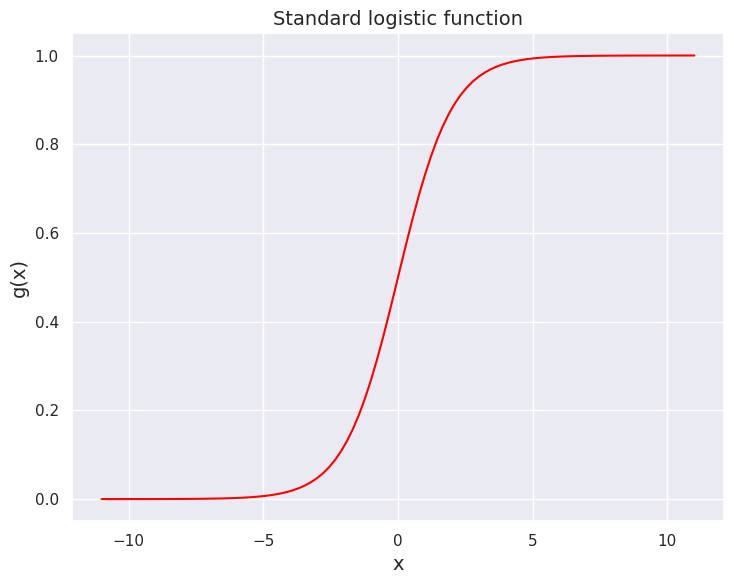

In [5]:
# Plotting the logistic function
plt.figure(figsize = (7.5, 6))
x = np.linspace(-11, 11, 100)
plt.plot(x, logistic(x), color = 'red')
plt.xlabel("x", fontsize = 14)
plt.ylabel("g(x)", fontsize = 14)
plt.title("Standard logistic function", fontsize = 14)
plt.tight_layout()
plt.show()

# Log Loss

The `loss function`, which corresponds to the *true value* and *predicted value* of a single observation. The `cost function` can be thought of as *expected loss* or *average loss* over a group of observations. Contrary to linear regression, which employs `squared loss`, logistic regression makes use of the `log loss` function, given by

$$ L(y, y') = -y \log\left(y'\right) - \left(1 - y\right) \log\left(1 - y'\right), $$

where $y$ is the true value of a binary target (taking values $0$ or $1$) and $y'$ is the prediction, which can be thought of as the predicted probability of $y$ being $1$. Observe that the loss is $0$, when the true value and predicted value agree with each other, i.e. $L(0, 0) = L(1, 1) = 0$. On the other hand, the loss explodes towards infinity if the predicted value approaches $1$ when the true value is $0$, or it approaches $0$ when the true value is $1$. Mathematically, $\lim_{t \to 1-} L(0, t) = \lim_{t \to 0+} L(1, t) = \infty$. In the next couple of code blocks, we construct the function to compute log loss and plot it for $y = 0$ and $y = 1$. Since the true values (labels) are always $0$ or $1$, we do not need to pay heed to the behaviour of the function $L$ for other values of $y$.

In [6]:
# Log loss
def log_loss(y, y_dash):
    """
    Computes log loss for inputs true value (0 or 1) and predicted value (between 0 and 1)
    Args:
      y      (scalar): true value (0 or 1)
      y_dash (scalar): predicted value (probability of y being 1)
    Returns:
      loss (float): nonnegative loss corresponding to y and y_dash
    """
    loss = - (y * np.log(y_dash)) - ((1 - y) * np.log(1 - y_dash))
    return loss

y, y_dash = 0, 0.6
print(f"log_loss({y}, {y_dash}) = {log_loss(y, y_dash)}")

log_loss(0, 0.6) = 0.916290731874155


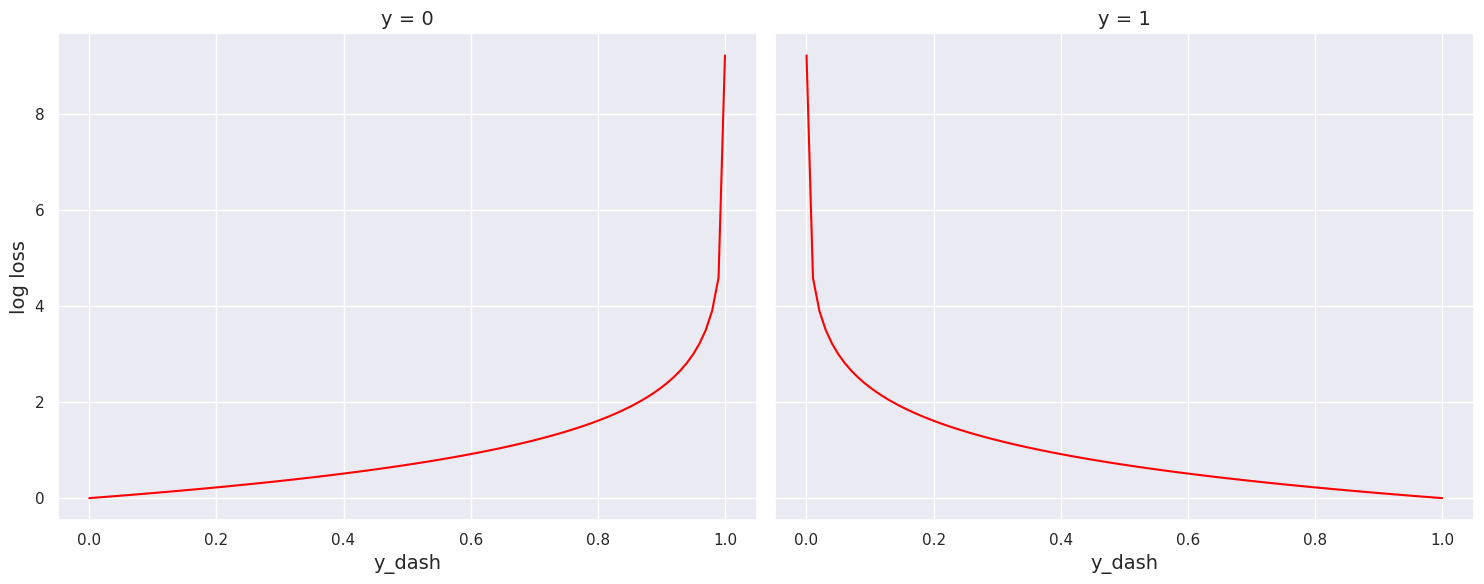

In [7]:
# Log loss for y = 0 and y = 1
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharex = True, sharey = True)
y_dash = np.linspace(0.0001, 0.9999, 100)
ax[0].plot(y_dash, log_loss(0, y_dash), color = 'red')
ax[0].set_title("y = 0", fontsize = 14)
ax[0].set_xlabel("y_dash", fontsize = 14)
ax[0].set_ylabel("log loss", fontsize = 14)
ax[1].plot(y_dash, log_loss(1, y_dash), color = 'red')
ax[1].set_title("y = 1", fontsize = 14)
ax[1].set_xlabel("y_dash", fontsize = 14)
plt.tight_layout()
plt.show()

The plots sync with the intuition that loss should be minimum when the predicted value (probability) matches the true value $(0$ or $1)$, and should increase as the two values drift apart.

# Cost Function

Let $\mathbf{y} = (y_1, y_2, \cdots, y_n)$ be the true values $(0$ or $1)$ and $\mathbf{y'} = (y_1', y_2', \cdots, y_n')$ be the corresponding predictions (probabilities). Then, the *cost function* is given by the average loss:

$$ C(\mathbf{y}, \mathbf{y'}) = \frac{1}{m}\sum_{i = 1}^m L(y_i, y_i'). $$

We construct the function to compute cost in the following two code blocks (the first one using for loop, the second one using vectorization). An important structural distinction from the log loss function is that here the arguments `y` and `y_dash` are vectors, not scalars.

In [8]:
# Cost function - using for loop
def cost_func(y, y_dash):
    """
    Computes log loss for inputs true value (0 or 1) and predicted value (between 0 and 1)
    Args:
      y      (array_like, shape (m,)): array of true values (0 or 1)
      y_dash (array_like, shape (m,)): array of predicted values (probability of y being 1)
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash
    """
    assert len(y) == len(y_dash), "Length of true values and length of predicted values do not match"
    m = len(y)
    cost = 0
    for i in range(m):
        cost += log_loss(y[i], y_dash[i])
    cost = cost / m
    return cost

y, y_dash = np.array([0, 1, 0]), np.array([0.4, 0.6, 0.25])
print(f"cost_func({y}, {y_dash}) = {cost_func(y, y_dash)}")

cost_func([0 1 0], [0.4  0.6  0.25]) = 0.43644443999458743


In [9]:
# Cost function - using vectorization
def cost_func_vec(y, y_dash):
    """
    Computes log loss for inputs true value (0 or 1) and predicted value (between 0 and 1)
    Args:
      y      (array_like, shape (m,)): array of true values (0 or 1)
      y_dash (array_like, shape (m,)): array of predicted values (probability of y being 1)
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash
    """
    assert len(y) == len(y_dash), "Length of true values and length of predicted values do not match"
    m = len(y)
    loss_vec = np.array([log_loss(y[i], y_dash[i]) for i in range(m)])
    cost = np.dot(loss_vec, np.ones(m)) / m
    return cost

y, y_dash = np.array([0, 1, 0]), np.array([0.4, 0.6, 0.25])
print(f"cost_func_vec({y}, {y_dash}) = {cost_func(y, y_dash)}")

cost_func_vec([0 1 0], [0.4  0.6  0.25]) = 0.43644443999458743


Let us assume that we want to predict $y$ based on $n$ features. In this setup, a logistic regression model is characterized by $n+1$ parameters:

- weight parameters $\mathbf{w} = (w_1, w_2, \cdots, w_n)$
- bias parameter $b$

Note that, the [dot product](https://en.wikipedia.org/wiki/Dot_product) of two vectors $\mathbf{a} = (a_1, a_2, \cdots, a_n)$ and $\mathbf{b} = (b_1, b_2, \cdots, b_n)$ is given by $\mathbf{a} \cdot \mathbf{b} = \sum_{i=1}^n a_ib_i$. It is a scalar value and evidently, $\mathbf{a} \cdot \mathbf{b} = \mathbf{b} \cdot \mathbf{a}$. Given the realized values of $n$ features $\mathbf{x} = (x_1, x_2, \cdots, x_n)$, the model feeds $\mathbf{x} \cdot \mathbf{w} + b$ to the logistic function $g$, and projects the output as the predicted probability of $y = 1$. Concretely, we have

$$ y' = g\left(\mathbf{x} \cdot \mathbf{w} + b\right) = \frac{1}{1 + e^{-\left(\mathbf{x} \cdot \mathbf{w} + b\right)}}. \tag{1} $$

Let us consider the situation of $m$ observations, with the $i$th observation having feature values $\mathbf{x_i} = (x_{i,1}, x_{i,2}, \cdots, x_{i,n})$, true target value $y_i$ and predicted probabilities $y_i' = g\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)$. Stacking them up, we obtain the feature matrix $\mathbf{X}$, target vector $\mathbf{y}$ and the vector of predicted probability $\mathbf{y'}$, as follows:

$$ \mathbf{X} = \begin{pmatrix}
\mathbf{x_1} \newline
\mathbf{x_2} \newline
\vdots \newline
\mathbf{x_m}
\end{pmatrix} = \begin{pmatrix}
x_{1,1} & x_{1,2} & \cdots & x_{1,n} \newline
x_{2,1} & x_{2,2} & \cdots & x_{2,n} \newline
\vdots & \vdots & \ddots & \vdots \newline
x_{m,1} & x_{m,2} & \cdots & x_{m,n}
\end{pmatrix},\;\;\;\;
\mathbf{y} = \begin{pmatrix}
y_1 \newline
y_2 \newline
\vdots \newline
y_m
\end{pmatrix},\;\;\;\;
\mathbf{y'} = \begin{pmatrix}
g\left(\mathbf{x_1} \cdot \mathbf{w} + b\right) \newline
g\left(\mathbf{x_2} \cdot \mathbf{w} + b\right) \newline
\vdots \newline
g\left(\mathbf{x_n} \cdot \mathbf{w} + b\right)
\end{pmatrix}. \tag{2} $$

Now, we are in a position to rewrite the cost function in terms of model parameters:

$$ J\left(\mathbf{w}, b\right) := C\left(\mathbf{y}, \mathbf{y'} \,\vert\, \mathbf{X}, \mathbf{w}, b \right) = \frac{1}{m}\sum_{i = 1}^m L\left(y_i, \frac{1}{1 + e^{-\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)}}\right) = \frac{1}{m}\sum_{i = 1}^m \left[ -y_i \log\left(\frac{1}{1 + e^{-\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)}}\right) - \left(1 - y_i\right) \log\left(1 - \frac{1}{1 + e^{-\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)}}\right) \right]. \tag{3} $$

Note that $J\left(\mathbf{0}, 0\right) = \log{2}$ for every input data $\mathbf{X}$ (features) and $\mathbf{y}$ (target). We construct a function to compute the cost, given data and model parameters, in the general setup of $n$ features (first using for loop, then using vectorization). Then, we visualize the cost function for a simplified setup, consisting of a single feature $x$. In this setup, the model involves two parameters only, the weight parameter $w$ and the bias parameter $b$.

In [10]:
# Function to compute cost function in terms of model parameters - using for loops
def cost_logreg(X, y, w, b):
    """
    Computes the cost function, given data and model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values (0 or 1) of target
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash 
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    z = []
    for i in range(m):
        s = 0
        for j in range(n):
            s += X[i, j] * w[j]
        z.append(s + b)
    z = np.array(z)
    y_dash = logistic(z)
    cost = cost_func(y, y_dash)
    return cost

X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"cost_logreg(X = {X}, y = {y}, w = {w}, b = {b}) = {cost_logreg(X, y, w, b)}")

cost_logreg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = 5.500008350784906


The code for logistic function $g$ is constructed in such a way that, if applied on an array, it acts separately on each component and returns an array. Using this, it follows from $(2)$ that

$$ \mathbf{y'} = g\left(\mathbf{X} \mathbf{w} + b \mathbf{1} \right), $$

where $\mathbf{1}$ has the same dimension as that of $\mathbf{X} \mathbf{w}$. We use [matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication) in computing $\mathbf{X} \mathbf{w}$, [scalar multiplication of a vector](https://en.wikipedia.org/wiki/Scalar_multiplication) in computing $b \mathbf{1}$ and add them up using [vector addition](https://en.wikipedia.org/wiki/Euclidean_vector#Addition_and_subtraction). This representation leads to a much faster vectorized implementation of computing the cost function in terms of model parameters.

In [11]:
# Function to compute cost function in terms of model parameters - using vectorization
def cost_logreg_vec(X, y, w, b):
    """
    Computes the cost function, given data and model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash 
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    z = np.matmul(X, w) + (b * np.ones(m))
    y_dash = logistic(z)
    cost = cost_func_vec(y, y_dash)
    return cost

X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"cost_logreg_vec(X = {X}, y = {y}, w = {w}, b = {b}) = {cost_logreg(X, y, w, b)}")

cost_logreg_vec(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = 5.500008350784906


[Text(0.5, 0, 'w'), Text(0.5, 0.5, 'b')]

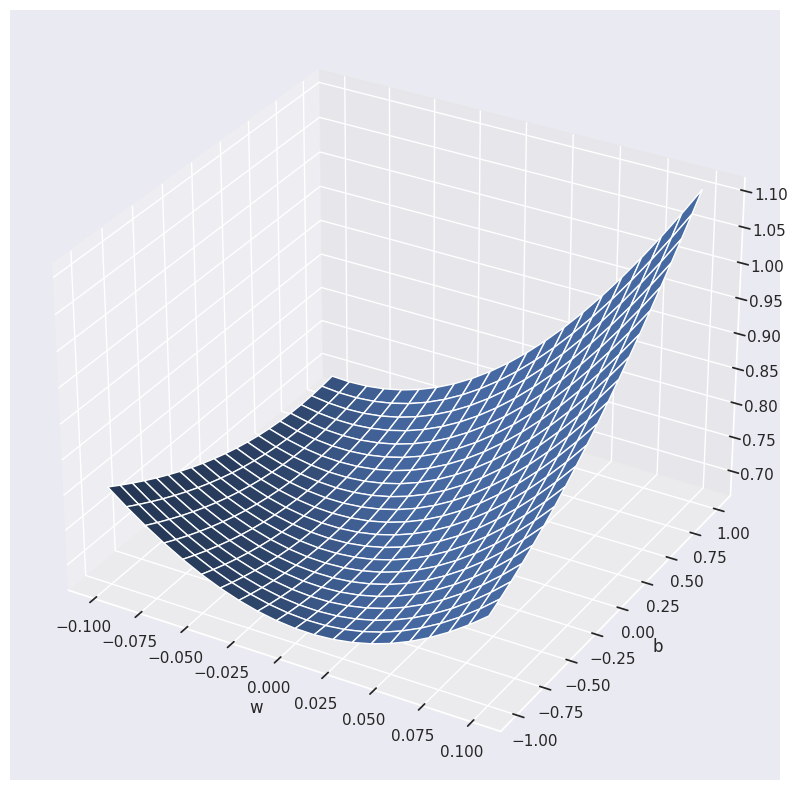

In [12]:
# Plotting the cost function against model parameters
from mpl_toolkits.mplot3d import Axes3D
w, b = np.meshgrid(np.linspace(-0.1, 0.1, 21), np.linspace(-1, 1, 21))
X = np.array([1.56, 0.76 , 0.08, 9.71, 4.65, 4.35, 7.34, 0.91, 9.82, 9.05]).reshape((10, 1))
y = np.array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0])
cost = np.array([[cost_logreg_vec(X, y, np.array([w0]), b0) for b0 in b[:, 0]] for w0 in w[0]])
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection = '3d')
ax.plot_surface(w, b, cost)
ax.set(xlabel = "w", ylabel = "b")

The prediction $y'$ in $(1)$ can be converted to a decision by using a threshold value. For instance, suppose we take the threshold to be $0.5$. Then, we may classify the observation to class $1$ if $y' \geq 0.5$, and to class $0$ otherwise. The problem, however, is that we do not know the model parameters $\mathbf{w}$ and $b$, and hence cannot compute $y'$ directly. First, we have to fit the model by finding the best fitting parameters. Observe that, given the training data, $C\left(\mathbf{y}, \mathbf{y'}\right)$ depends on $\mathbf{w}$ and $b$ only. A reasonable strategy, therefore, is:

$$ \text{To minimise } J\left(\mathbf{w}, b\right), \text{ with respect to } \mathbf{w} \text{ and } b. $$

We shall employ the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) [algorithm](https://en.wikipedia.org/wiki/Algorithm) to solve this [optimization](https://en.wikipedia.org/wiki/Mathematical_optimization) problem.

# Gradient Descent

**What is it?** The gradient descent algorithm is a [first order](https://en.wikipedia.org/wiki/Category:First_order_methods) [iterative](https://en.wikipedia.org/wiki/Iterative_method) optimization algorithm for finding a [local minimum](https://en.wikipedia.org/wiki/Maxima_and_minima) of a differentiable function. The idea is to take repeated steps in the opposite direction of the [gradient](https://en.wikipedia.org/wiki/Gradient) (or approximate gradient) of the function at the current point, because this is the direction of steepest descent. Conversely, stepping in the direction of the gradient will lead to a local maximum of that function. This procedure is then known as *gradient ascent*.

**History.** Gradient descent is generally attributed to [Augustin-Louis Cauchy](https://en.wikipedia.org/wiki/Augustin-Louis_Cauchy), who first suggested it in 1847. [Jacques Hadamard](https://en.wikipedia.org/wiki/Jacques_Hadamard) independently proposed a similar method in 1907. Its convergence properties for non-linear optimization problems were first studied by [Haskell Curry](https://en.wikipedia.org/wiki/Haskell_Curry) in 1944, with the method becoming increasingly well-studied and used in the following decades.

**The algorithm.** In the context of minimising the cost function $J$, with respect to the model parameters $\mathbf{w}$ and $b$, the gradient descent algorithm is given by:

$$ \begin{align*}
& \text{repeat until convergence:}\; \{ \newline
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j},\; \text{ for } j = 1, 2, \ldots, n; \newline
& b := b -  \alpha \frac{\partial J(\mathbf{w}, b)}{\partial b}. \tag{4} \newline
& \}
\end{align*} $$

where $\alpha$ is the [learning rate](https://en.wikipedia.org/wiki/Learning_rate), and the parameters $\mathbf{w} = (w_1, w_2, \cdots, w_n)$ and $b$ are updated simultaniously in each iteration.

**Computing gradient.** Before we can implement the gradient descent algorithm, we need to compute the gradients first! From $(3)$, we can compute the partial derivatives of $J$ with respect to $w_j$ and $b$ as follows:

$$ \begin{align*}
& \frac{\partial J(\mathbf{w},b)}{\partial w_j} = \frac{1}{m} \sum\limits_{i = 1}^m \left(\frac{1}{1 + e^{-\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)}} - y_i\right) x_{i,j},\;\; \text{ for } j = 1, 2, \ldots, n; \newline
& \frac{\partial J(\mathbf{w}, b)}{\partial b} = \frac{1}{m} \sum\limits_{i = 1}^m \left(\frac{1}{1 + e^{-\left(\mathbf{x_i} \cdot \mathbf{w} + b\right)}} - y_i\right).
\end{align*} $$

The next code blocks construct a function to compute these gradients, first using for loops, then using vectorization.

In [13]:
# Function to compute gradients of the cost function with respect to model parameters - using for loops
def grad_logreg(X, y, w, b):
    """
    Computes gradients of the cost function with respect to model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      grad_w (array_like, shape (n,)): gradients of the cost function with respect to the weight parameters
      grad_b (float)                 : gradient of the cost function with respect to the bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    grad_w, grad_b = np.zeros(n), 0
    for i in range(m):
        s = 0
        for j in range(n):
            s += X[i, j] * w[j]
        y_dash_i = logistic(s + b)
        for j in range(n):
            grad_w[j] += (y_dash_i  - y[i]) * X[i,j]
        grad_b += y_dash_i  - y[i]
    grad_w, grad_b = grad_w / m, grad_b / m
    return grad_w, grad_b

X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"grad_logreg(X = {X}, y = {y}, w = {w}, b = {b}) = {grad_logreg(X, y, w, b)}")

grad_logreg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = (array([-4.99991649,  4.99991649]), 0.4999916492890759)


In [14]:
# Function to compute gradients of the cost function with respect to model parameters - using vectorization
def grad_logreg_vec(X, y, w, b): 
    """
    Computes gradients of the cost function with respect to model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
    Returns:
      grad_w (array_like, shape (n,)): gradients of the cost function with respect to the weight parameters
      grad_b (float)                 : gradient of the cost function with respect to the bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    y_dash = logistic(np.matmul(X, w) + b * np.ones(m))
    grad_w = np.matmul(y_dash - y, X) / m
    grad_b = np.dot(y_dash - y, np.ones(m)) / m
    return grad_w, grad_b

X, y, w, b = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1
print(f"grad_logreg_vec(X = {X}, y = {y}, w = {w}, b = {b}) = {grad_logreg_vec(X, y, w, b)}")

grad_logreg_vec(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1) = (array([-4.99991649,  4.99991649]), 0.4999916492890759)


Armed with the required functions, we can now implement the gradient descent algorithm, given in $(4)$. 

In [15]:
# Gradient descent algorithm for logistic regression
def grad_desc(X, y, w, b, alpha, n_iter, show_cost = True, show_params = False): 
    """
    Implements batch gradient descent algorithm to learn and update model parameters
    with prespecified number of interations and learning rate
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): true values of target (0 or 1)
      w (array_like, shape (n,)): initial value of weight parameters
      b (scalar)                : initial value of bias parameter
      cost_func                 : function to compute cost
      grad_func                 : function to compute gradients of cost with respect to model parameters
      alpha (float)             : learning rate
      n_iter (int)              : number of iterations
    Returns:
      w (array_like, shape (n,)): updated values of weight parameters
      b (scalar)                : updated value of bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    cost_history, params_history = [], []
    for i, j in itertools.product(range(n_iter), range(1)):
        grad_w, grad_b = grad_logreg_vec(X, y, w, b)   
        w += - alpha * grad_w
        b += - alpha * grad_b
        cost =  cost_logreg_vec(X, y, w, b)
        cost_history.append(cost)
        params_history.append([w, b])
        if show_cost == True and show_params == False and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Iteration {i:6}:    Cost  {float(cost_history[i]):3.4f}")
        if show_cost == True and show_params == True and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Iteration {i:6}:    Cost  {float(cost_history[i]):3.4f},    Params  {params_history[i]}")
    return w, b, cost_history, params_history

X, y, w, b, alpha, n_iter = np.array([[0.1, 0.2], [-0.1, 0.1]]), np.array([1, 0]), np.array([0., 0.]), 0., 0.1, 100000
w_out, b_out, cost_history, params_history = grad_desc(X, y, w, b, alpha, n_iter, show_cost = True, show_params = True)

  0%|          | 0/100000 [00:00<?, ?it/s]

Iteration      0:    Cost  0.6928,    Params  [array([0.005 , 0.0025]), 0.0]
Iteration  10000:    Cost  0.0867,    Params  [array([19.30073125,  9.43918518]), -1.4078696585361676]
Iteration  20000:    Cost  0.0430,    Params  [array([25.11290735, 12.28127422]), -1.8345297190719223]
Iteration  30000:    Cost  0.0283,    Params  [array([28.51960605, 13.947125  ]), -2.084520137444322]
Iteration  40000:    Cost  0.0211,    Params  [array([30.9258698 , 15.12377399]), -2.261072754000601]
Iteration  50000:    Cost  0.0168,    Params  [array([32.78441957, 16.03259549]), -2.397428663482232]
Iteration  60000:    Cost  0.0139,    Params  [array([34.29765304, 16.77255979]), -2.5084448658725664]
Iteration  70000:    Cost  0.0119,    Params  [array([35.57340822, 17.39639871]), -2.602035975617821]
Iteration  80000:    Cost  0.0104,    Params  [array([36.67589743, 17.93551157]), -2.682914282617459]
Iteration  90000:    Cost  0.0092,    Params  [array([37.64642667, 18.4100967 ]), -2.7541108549220774]
I

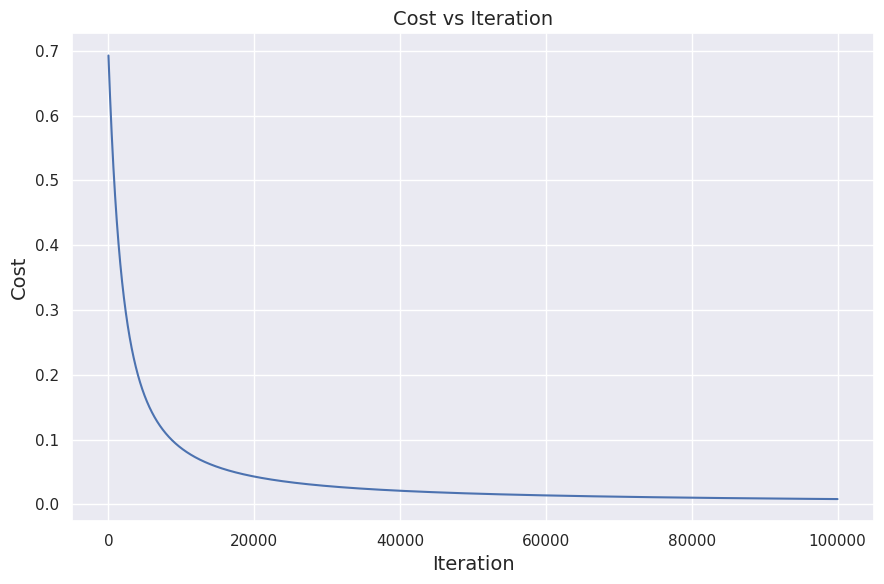

In [16]:
# Plotting cost over iteration
plt.figure(figsize = (9, 6))
plt.plot(cost_history)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Iteration", fontsize = 14)
plt.tight_layout()
plt.show()

# Preprocessing

The columns `EventId` and `Weight` will not be used in this notebook. Thus we drop these columns. Even though there are no `NaN` values in the dataset, we observe that several columns unnaturally contain the value $-999$ for many observations. We suspect that these are missing/corrupted values that have been replaced with $-999$ and we convert them to `np.nan`. We shall impute these values after *train-test split*. Furthermore, we encode the `Label` column as follows: $b \mapsto 0$ and $s \mapsto 1$.

In [17]:
# Dropping unnecessary columns
data.drop(['EventId', 'Weight'], axis = 1, inplace = True)

# Replacing -999 with nan
data.replace(to_replace = -999, value = np.nan, inplace = True)

# Encoding the 'Label' column
label_dict = {'b': 0, 's': 1}
data.replace({'Label': label_dict}, inplace = True)

Next, we split `data` into two parts:

- `data_train` : The portion of data that we use to train the models
- `data_test` : The portion of data that we use to test or evaluate the models

In [18]:
# Train-test split
data_train, data_test = train_test_split(data, test_size = 0.2, random_state = 40)

Next, we identify $11$ columns with missing values. Among them, $10$ columns have more than $30\%$ data missing, and hence we shall discard them. The column `DER_mass_MMC` has about $15.25\%$ data missing. We shall impute the missing values in this column by the median of the rest of the values in the column.

In [19]:
# Columns with missing values with respective proportions
(data.isna().sum()[data.isna().sum() > 0] / len(data)).sort_values(ascending = False)

DER_deltaeta_jet_jet      0.709828
DER_mass_jet_jet          0.709828
DER_prodeta_jet_jet       0.709828
DER_lep_eta_centrality    0.709828
PRI_jet_subleading_pt     0.709828
PRI_jet_subleading_eta    0.709828
PRI_jet_subleading_phi    0.709828
PRI_jet_leading_pt        0.399652
PRI_jet_leading_eta       0.399652
PRI_jet_leading_phi       0.399652
DER_mass_MMC              0.152456
dtype: float64

In [20]:
# Discarding columns with more than 30% missing data
cols_missing_drop = [
    'DER_deltaeta_jet_jet',
    'DER_mass_jet_jet',
    'DER_prodeta_jet_jet',
    'DER_lep_eta_centrality',
    'PRI_jet_subleading_pt',
    'PRI_jet_subleading_eta',
    'PRI_jet_subleading_phi',
    'PRI_jet_leading_pt',
    'PRI_jet_leading_eta',
    'PRI_jet_leading_phi'
]
data_train.drop(cols_missing_drop, axis = 1, inplace = True)
data_test.drop(cols_missing_drop, axis = 1, inplace = True)

In [21]:
# Median imputation
data_train['DER_mass_MMC'].fillna(data_train['DER_mass_MMC'].median(), inplace = True)
data_test['DER_mass_MMC'].fillna(data_test['DER_mass_MMC'].median(), inplace = True)

Next, we shall split the data into features and target.

In [22]:
# Features-target split
X_train, y_train = data_train.drop('Label', axis = 1), data_train['Label']
X_test, y_test = data_test.drop('Label', axis = 1), data_test['Label']

We normalize the data, so that each column has values in the similar scale.

In [23]:
# Min-Max normalization
for col in X_train.columns:
    if (X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64') and X_train[col].nunique() > 1:
        X_train[col] = (X_train[col] - X_train[col].min()) / (X_train[col].max() - X_train[col].min())
for col in X_test.columns:
    if (X_test[col].dtypes == 'int64' or X_test[col].dtypes == 'float64') and X_test[col].nunique() > 1:
        X_test[col] = (X_test[col] - X_test[col].min()) / (X_test[col].max() - X_test[col].min())

# Model Fitting

We fix the initial values of the parameters, based on running the algorithm several times and noting down the final parameter values. It gives us a better *starting point* and helps to achieve a better performance in a limited number of iterations.

In [24]:
# Initial values of the model parameters
w_init = np.array([-5, -15, -10, 9, 4, -6, 3, -10, 1, 14, 0, 0, 15, 0, 0, 7, 0, -3, 1, -8]).astype(float)
b_init = -1.

In [25]:
# Learning model parameters using gradient descent algorithm
w_out, b_out, cost_history, params_history = grad_desc(X_train.to_numpy(),
                                                       y_train.to_numpy(),
                                                       w = w_init, # np.zeros(X_train.shape[1]),
                                                       b = b_init, # 0,
                                                       alpha = 0.1,
                                                       n_iter = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration      0:    Cost  0.5279
Iteration    200:    Cost  0.5251
Iteration    400:    Cost  0.5249
Iteration    600:    Cost  0.5248
Iteration    800:    Cost  0.5247
Iteration   1000:    Cost  0.5247
Iteration   1200:    Cost  0.5246
Iteration   1400:    Cost  0.5246
Iteration   1600:    Cost  0.5245
Iteration   1800:    Cost  0.5245
Iteration   1999:    Cost  0.5245


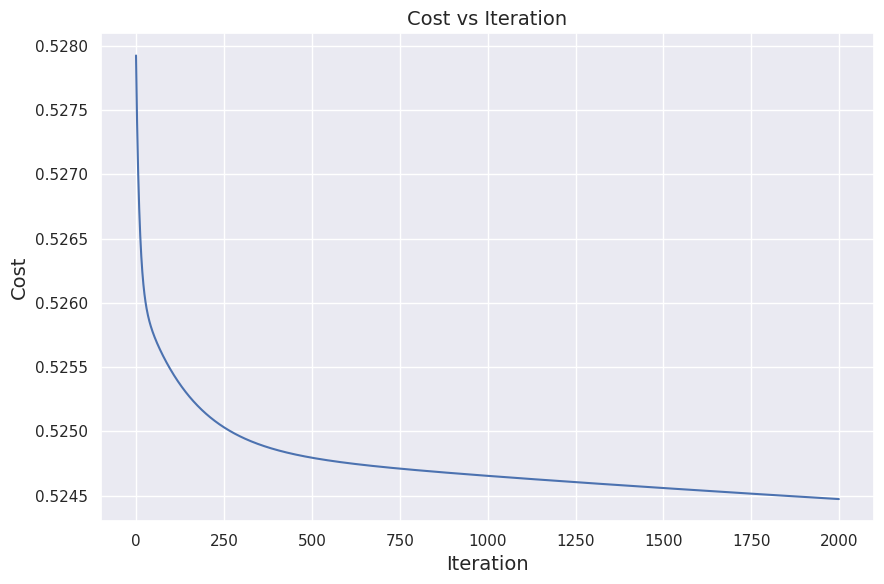

In [26]:
# Plotting cost over iteration
plt.figure(figsize = (9, 6))
plt.plot(cost_history)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Iteration", fontsize = 14)
plt.tight_layout()
plt.show()

In [27]:
# Final parameter values
params_history[-1]

[array([-4.95127961e+00, -1.49752482e+01, -1.00644031e+01,  9.02706020e+00,
         4.21406246e+00, -6.01131593e+00,  3.06723522e+00, -1.00909874e+01,
         7.72160230e-01,  1.40217105e+01, -2.85854684e-02, -7.85630447e-03,
         1.49515838e+01, -1.78010698e-02,  5.14209826e-03,  7.04187845e+00,
         1.60721831e-02, -2.95066091e+00,  8.44831149e-01, -7.91970725e+00]),
 -1.0392168256328713]

# Prediction and Evaluation

First, we construct some functions to compute and display the *confusion matrix*, and to compute *accuracy*, given the true labels and the predicted labels of the target.

In [28]:
# Function to compute confusion matrix
def conf_mat(y_test, y_pred):
    """
    Computes confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      confusion_mat (array): A 2D array representing a 2x2 confusion matrix
    """
    y_test, y_pred = list(y_test), list(y_pred)
    count, labels, confusion_mat = len(y_test), [0, 1], np.zeros(shape = (2, 2), dtype = int)
    for i in range(2):
        for j in range(2):
            confusion_mat[i][j] = len([k for k in range(count) if y_test[k] == labels[i] and y_pred[k] == labels[j]])
    return confusion_mat

In [29]:
# Function to print confusion matrix
def conf_mat_heatmap(y_test, y_pred):
    """
    Prints confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      Nothing, prints a heatmap representing a 2x2 confusion matrix
    """
    confusion_mat = conf_mat(y_test, y_pred)
    labels, confusion_mat_df = [0, 1], pd.DataFrame(confusion_mat, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    sns.heatmap(confusion_mat_df, annot = True, annot_kws = {"size": 16}, fmt = 'd')
    plt.xticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.yticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.xlabel("Predicted label", fontsize = 14)
    plt.ylabel("True label", fontsize = 14)
    plt.title("Confusion Matrix", fontsize = 14)
    plt.grid(False)
    plt.show()

In [30]:
# Function to compute accuracy
def accuracy(y_test, y_pred):
    """
    Computes accuracy, given true and predicted binary (0 or 1) labels
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      acc (float): accuracy obtained from y_test and y_pred
    """
    confusion_mat = conf_mat(y_test, y_pred)
    num = confusion_mat[0, 0] + confusion_mat[1, 1] # Number of correct predictions
    denom = num + confusion_mat[0, 1] + confusion_mat[1, 0] # Number of total predictions
    acc = num / denom
    return acc

In [31]:
# Prediction and evaluation on the training set and the test set
y_train_prob = logistic(np.matmul(X_train.to_numpy(), w_out) + (b_out * np.ones(X_train.shape[0])))
y_test_prob = logistic(np.matmul(X_test.to_numpy(), w_out) + (b_out * np.ones(X_test.shape[0])))
y_train_pred, y_test_pred = (y_train_prob > 0.5).astype(int), (y_test_prob > 0.5).astype(int)
print(pd.Series({"Training accuracy": accuracy(y_train, y_train_pred),
                 "Test accuracy": accuracy(y_test, y_test_pred)}).to_string())

Training accuracy    0.72795
Test accuracy        0.71992


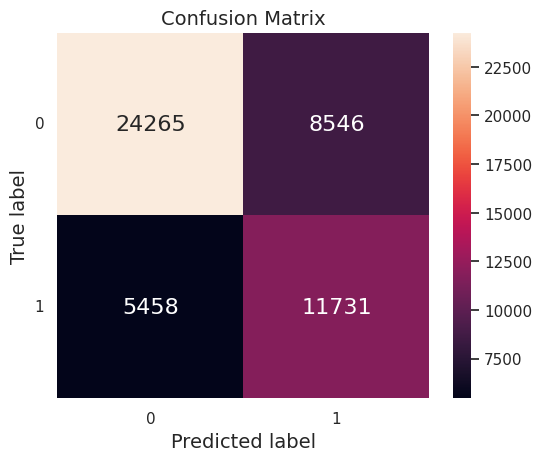

In [32]:
# Confusion matrix for predictions on the test set
conf_mat_heatmap(y_test, y_test_pred)

# Regularization

*Regularization* provides a tool to deal with overfitting. Essentially it puts a restriction the parameter values by adding a term in the cost function. This way, it prevents the model from fitting *too well* on the training set and failing to generalize on the test set. The following is one way to do this:

$$ \text{new } J(\mathbf{w}, b) := \text{old } J(\mathbf{w}, b) + \frac{\lambda}{2m} \sum_{j=1}^n w_j^2, \tag{5} $$

where $\lambda \geq 0$ is called the regularization parameter. Evidently, if $\lambda = 0$, we get back the previous setup. Thus, the new cost function, parameterized by $\lambda$, gives a generalization of the setup described in the previous sections. The setup in $(5)$ is referred to as the $L_2$ regularization, as the regularization term essentially is $(\lambda/2m)\,\left\Vert \mathbf{w} \right\Vert_2^2$, i.e. the [$l^2$ norm](https://mathworld.wolfram.com/L2-Norm.html) of $\mathbf{w}$, multiplied by the term $(\lambda/2m)$. In this section, we shall employ the $L_2$ regularization on the cost function, given in $(3)$, and check if it improves performance of the logistic regression model, derived thence. We rewrite the functions to compute cost, gradient and to implement gradient descent algorithm, incorporating regularization with the extra parameter $l$.

In [33]:
# Function to compute regularized cost function in terms of model parameters - using for loops
def cost_logreg_reg(X, y, w, b, l):
    """
    Computes the cost function, given data and model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values (0 or 1) of target
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
      l (float)                 : regularization parameter
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash 
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    cost = cost_logreg(X, y, w, b)
    for j in range(n):
        cost += (l / (2 * m)) * (w[j]**2)
    return cost

X, y, w, b, l = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1, 1
print(f"cost_logreg(X = {X}, y = {y}, w = {w}, b = {b}, l = {l}) = {cost_logreg_reg(X, y, w, b, l)}")

cost_logreg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1, l = 1) = 6.125008350784906


In [34]:
# Function to compute regularized cost function in terms of model parameters - using vectorization
def cost_logreg_vec_reg(X, y, w, b, l):
    """
    Computes the cost function, given data and model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values (0 or 1) of target
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
      l (float)                 : regularization parameter
    Returns:
      cost (float): nonnegative cost corresponding to y and y_dash 
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    cost = cost_logreg_vec(X, y, w, b)
    cost += (l / (2 * m)) * np.dot(w, w)
    return cost

X, y, w, b, l = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1, 1
print(f"cost_logreg_vec_reg(X = {X}, y = {y}, w = {w}, b = {b}, l = {l}) = {cost_logreg_vec_reg(X, y, w, b, l)}")

cost_logreg_vec_reg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1, l = 1) = 6.125008350784906


From $(5)$, we can compute the modified partial derivatives of $J$ with respect to $w_j$ and $b$ as follows:

$$ \begin{align*}
& \text{new } \frac{\partial J(\mathbf{w},b)}{\partial w_j} = \text{old } \frac{\partial J(\mathbf{w},b)}{\partial w_j} + \frac{\lambda}{m} w_j,\;\; \text{ for } j = 1, 2, \ldots, n; \newline
& \text{new } \frac{\partial J(\mathbf{w}, b)}{\partial b} = \text{old } \frac{\partial J(\mathbf{w}, b)}{\partial b}.
\end{align*} $$

We construct a function to compute these gradients, first using for loops, then using vectorization.

In [35]:
# Function to compute gradients of the regularized cost function with respect to model parameters - using for loops
def grad_logreg_reg(X, y, w, b, l):
    """
    Computes gradients of the cost function with respect to model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
      l (float)                 : regularization parameter
    Returns:
      grad_w (array_like, shape (n,)): gradients of the cost function with respect to the weight parameters
      grad_b (float)                 : gradient of the cost function with respect to the bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    grad_w, grad_b = grad_logreg(X, y, w, b)
    for j in range(n):
        grad_w[j] += (l / m) * w[j]
    return grad_w, grad_b

X, y, w, b, l = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1, 1
print(f"grad_logreg(X = {X}, y = {y}, w = {w}, b = {b}, l = {l}) = {grad_logreg_reg(X, y, w, b, l)}")

grad_logreg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1, l = 1) = (array([-4.74991649,  5.74991649]), 0.4999916492890759)


In [36]:
# Function to compute gradients of the regularized cost function with respect to model parameters - using vectorization
def grad_logreg_vec_reg(X, y, w, b, l):
    """
    Computes gradients of the cost function with respect to model parameters
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): array of true values of target (0 or 1)
      w (array_like, shape (n,)): weight parameters of the model      
      b (float)                 : bias parameter of the model
      l (float)                 : regularization parameter
    Returns:
      grad_w (array_like, shape (n,)): gradients of the cost function with respect to the weight parameters
      grad_b (float)                 : gradient of the cost function with respect to the bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    grad_w, grad_b = grad_logreg_vec(X, y, w, b)
    grad_w += (l / m) * w
    return grad_w, grad_b

X, y, w, b, l = np.array([[10, 20], [-10, 10]]), np.array([1, 0]), np.array([0.5, 1.5]), 1, 1
print(f"grad_logreg_vec_reg(X = {X}, y = {y}, w = {w}, b = {b}, l = {l}) = {grad_logreg_vec_reg(X, y, w, b, l)}")

grad_logreg_vec_reg(X = [[ 10  20]
 [-10  10]], y = [1 0], w = [0.5 1.5], b = 1, l = 1) = (array([-4.74991649,  5.74991649]), 0.4999916492890759)


Using the regularised cost function and its gradients with respect to the model parameters, we construct a function to implement the gradient descent algorithm for logistic regression, incorporating regularization. Specifically, the algorithm learns the model parameters, with the goal of minimizing the regularised cost function in $(5)$, instead of the usual cost function in $(3)$.

In [37]:
# Gradient descent algorithm for logistic regression with regularization
def grad_desc_reg(X, y, w, b, l, alpha, n_iter, show_cost = True, show_params = False): 
    """
    Implements batch gradient descent algorithm to learn and update model parameters
    with prespecified number of interations and learning rate
    Args:
      X (ndarray, shape (m,n))  : data on features, m observations with n features
      y (array_like, shape (m,)): true values of target (0 or 1)
      w (array_like, shape (n,)): initial value of weight parameters
      b (scalar)                : initial value of bias parameter
      l (float)                 : regularization parameter
      alpha (float)             : learning rate
      n_iter (int)              : number of iterations
    Returns:
      w (array_like, shape (n,)): updated values of weight parameters
      b (scalar)                : updated value of bias parameter
    """
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match"
    assert len(w) == n, "Number of features and number of weight parameters do not match"
    cost_history, params_history = [], []
    for i, j in itertools.product(range(n_iter), range(1)):
        grad_w, grad_b = grad_logreg_vec_reg(X, y, w, b, l)   
        w += - alpha * grad_w
        b += - alpha * grad_b
        cost =  cost_logreg_vec_reg(X, y, w, b, l)
        cost_history.append(cost)
        params_history.append([w, b])
        if show_cost == True and show_params == False and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Iteration {i:6}:    Cost  {float(cost_history[i]):3.4f}")
        if show_cost == True and show_params == True and (i % math.ceil(n_iter / 10) == 0 or i == n_iter - 1):
            print(f"Iteration {i:6}:    Cost  {float(cost_history[i]):3.4f},    Params  {params_history[i]}")
    return w, b, cost_history, params_history

We use the same initial values for the model parameters as in the unregularized implementation.

In [38]:
# Initial values of the model parameters
w_init = np.array([-5, -15, -10, 9, 4, -6, 3, -10, 1, 14, 0, 0, 15, 0, 0, 7, 0, -3, 1, -8]).astype(float)
b_init = -1.

In [39]:
# Learning model parameters using gradient descent algorithm
w_out_reg, b_out_reg, cost_history_reg, params_history_reg = grad_desc_reg(X_train.to_numpy(),
                                                                           y_train.to_numpy(),
                                                                           w = w_init, # np.zeros(X_train.shape[1]),
                                                                           b = b_init, # 0,
                                                                           l = 1.,
                                                                           alpha = 0.1,
                                                                           n_iter = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration      0:    Cost  0.5308
Iteration    200:    Cost  0.5280
Iteration    400:    Cost  0.5277
Iteration    600:    Cost  0.5276
Iteration    800:    Cost  0.5275
Iteration   1000:    Cost  0.5275
Iteration   1200:    Cost  0.5275
Iteration   1400:    Cost  0.5274
Iteration   1600:    Cost  0.5274
Iteration   1800:    Cost  0.5274
Iteration   1999:    Cost  0.5273


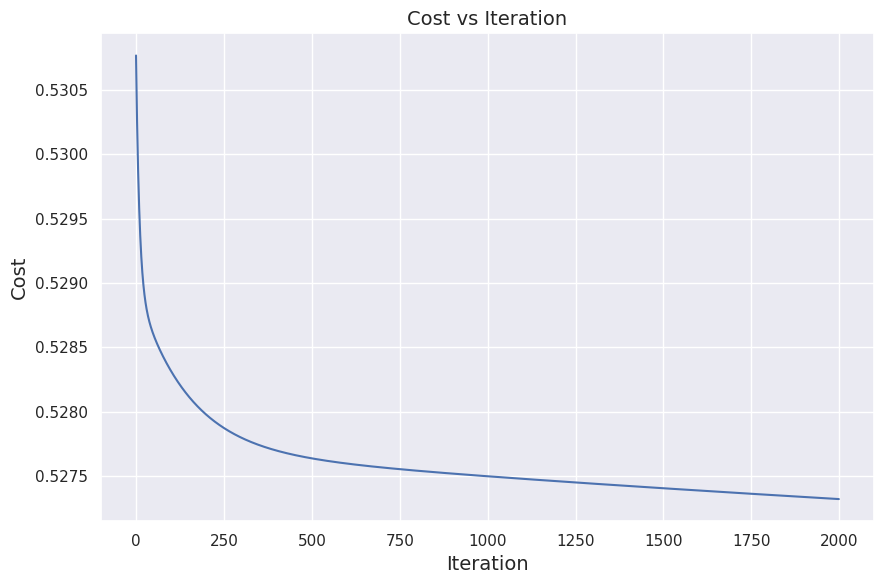

In [40]:
# Plotting cost over iteration
plt.figure(figsize = (9, 6))
plt.plot(cost_history_reg)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Iteration", fontsize = 14)
plt.tight_layout()
plt.show()

In [41]:
# Final parameter values
params_history_reg[-1]

[array([-4.94628559e+00, -1.49607208e+01, -1.00543532e+01,  9.01809026e+00,
         4.21009912e+00, -6.00532340e+00,  3.06428729e+00, -1.00811742e+01,
         7.72328943e-01,  1.40078919e+01, -2.85911045e-02, -7.87521465e-03,
         1.49365729e+01, -1.78038152e-02,  5.12711472e-03,  7.03484041e+00,
         1.60760953e-02, -2.94763742e+00,  8.44128051e-01, -7.91172875e+00]),
 -1.0392586732889664]

In [42]:
# Prediction and evaluation on the training set and the test set
y_train_prob_reg = logistic(np.matmul(X_train.to_numpy(), w_out_reg) + (b_out_reg * np.ones(X_train.shape[0])))
y_test_prob_reg = logistic(np.matmul(X_test.to_numpy(), w_out_reg) + (b_out_reg * np.ones(X_test.shape[0])))
y_train_pred_reg, y_test_pred_reg = (y_train_prob_reg > 0.5).astype(int), (y_test_prob_reg > 0.5).astype(int)
print(pd.Series({"Training accuracy": accuracy(y_train, y_train_pred_reg),
                 "Test accuracy": accuracy(y_test, y_test_pred_reg)}).to_string())

Training accuracy    0.727915
Test accuracy        0.719900


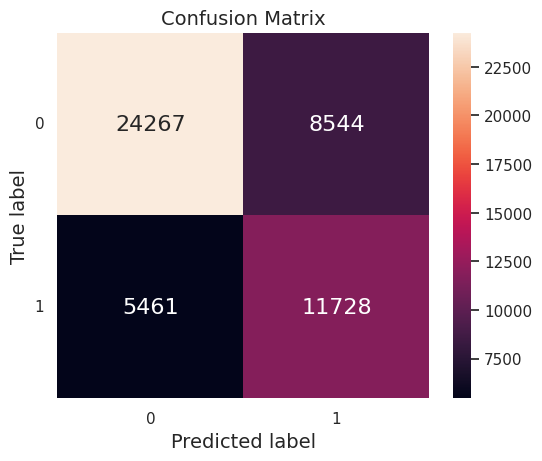

In [43]:
# Confusion matrix for predictions on the test set
conf_mat_heatmap(y_test, y_test_pred_reg)

Thus, in this scenario, regularization does not help much. This is expected since the unregularized implementation does not indicate overfitting.

# Acknowledgements

- [Higgs Boson Machine Learning Challenge](https://www.kaggle.com/competitions/higgs-boson)
- [The HiggsML challenge documentation](https://higgsml.ijclab.in2p3.fr/documentation/)

# References

- [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost)
- [Algorithm](https://en.wikipedia.org/wiki/Algorithm)
- [Augustin-Louis Cauchy](https://en.wikipedia.org/wiki/Augustin-Louis_Cauchy)
- [Binary classification](https://en.wikipedia.org/wiki/Binary_classification)
- [Bounded function](https://en.wikipedia.org/wiki/Bounded_function)
- [Classification rule](https://en.wikipedia.org/wiki/Classification_rule)
- [Decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning)
- [Differentiable function](https://en.wikipedia.org/wiki/Differentiable_function)
- [Dot product](https://en.wikipedia.org/wiki/Dot_product)
- [Evaluation metric](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers)
- [First order methods](https://en.wikipedia.org/wiki/Category:First_order_methods)
- [Fundamental interaction](https://en.wikipedia.org/wiki/Fundamental_interaction)
- [Gradient](https://en.wikipedia.org/wiki/Gradient)
- [Gradient descent algorithm](https://en.wikipedia.org/wiki/Gradient_descent)
- [Haskell Curry](https://en.wikipedia.org/wiki/Haskell_Curry)
- [Inflection point](https://en.wikipedia.org/wiki/Inflection_point)
- [Iterative method](https://en.wikipedia.org/wiki/Iterative_method)
- [Jacques Hadamard](https://en.wikipedia.org/wiki/Jacques_Hadamard)
- [$k$-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
- [$l^2$ norm](https://mathworld.wolfram.com/L2-Norm.html)
- [Learning rate](https://en.wikipedia.org/wiki/Learning_rate)
- [Linear discriminant analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)
- [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [Machine learning](https://en.wikipedia.org/wiki/Machine_learning)
- [Mathematical optimization](https://en.wikipedia.org/wiki/Mathematical_optimization)
- [Matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication)
- [Maxima and minima](https://en.wikipedia.org/wiki/Maxima_and_minima)
- [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [Neural network](https://en.wikipedia.org/wiki/Artificial_neural_network)
- [Particle physics](https://en.wikipedia.org/wiki/Particle_physics)
- [Random forest](https://en.wikipedia.org/wiki/Random_forest)
- [Scalar multiplication](https://en.wikipedia.org/wiki/Scalar_multiplication)
- [Scikit-learn](https://en.wikipedia.org/wiki/Scikit-learn)
- [Sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function)
- [Sorting hat](https://en.wikipedia.org/wiki/Magical_objects_in_Harry_Potter#Sorting_Hat)
- [Statistical classification](https://en.wikipedia.org/wiki/Statistical_classification)
- [Statistics](https://en.wikipedia.org/wiki/Statistics)
- [Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)
- [Subatomic particle](https://en.wikipedia.org/wiki/Subatomic_particle)
- [Supervised learning](https://en.wikipedia.org/wiki/Supervised_learning)
- [Support vector machine](https://en.wikipedia.org/wiki/Support-vector_machine)
- [Test data](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets#Test_data_set)
- [Training data](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets#Training_data_set)
- [Vector addition](https://en.wikipedia.org/wiki/Euclidean_vector#Addition_and_subtraction)
- [XGBoost](https://en.wikipedia.org/wiki/XGBoost)


In [44]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         2943.47 seconds
Process memory usage          552.60 MB
